In [1]:
from os import makedirs, path
from datetime import datetime

class Configuration(object):
    def __init__(self, conf_dct):
        assert isinstance(conf_dct, dict), \
            f"expect dict, got {type(conf_dct)}"
        self.__dict__.update(conf_dct)
        self.begin = datetime.strptime(str(self.begin), "%Y%m%d")
        self.end = datetime.strptime(str(self.end), "%Y%m%d")
        if not path.exists(self.report_root):
            makedirs(self.report_root)

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from time import time

from func.utils import timeit

class FileFormatError(Exception):
    pass

class DataProxy(object):
    def __init__(self, cfg):
        self._cfg = cfg

    @timeit
    def get_factor_data(self):
        path = self._cfg.factor_path
        try:
            begin_date = self._cfg.begin
            end_date = self._cfg.end
            df = pd.read_pickle(path)
            df["trade_date"] = pd.to_datetime(df["trade_date"], format="%Y%m%d")
            df = df[(begin_date <= df.trade_date) & (df.trade_date <= end_date)]
        except Exception as e:
            raise FileFormatError(f"[{path}] with wrong format:[{e}]")
        return df
    
    @timeit
    def get_market_data(self):
        path = self._cfg.market_path
        try:
            begin_date = self._cfg.begin
            end_date = self._cfg.end
            df = pd.read_pickle(path)
            df = df[(begin_date <= df.trade_date) & (df.trade_date <= end_date + timedelta(days=1))]
        except Exception as e:
            raise FileExistsError(f"[{path}] with wrong format: [{e}]")
        return df

In [3]:
import yaml

cfg_dct = yaml.load(open('param.yaml'))
cfg = Configuration(cfg_dct)

data_proxy = DataProxy(cfg)

alpha_df = data_proxy.get_factor_data()

market_df = data_proxy.get_market_data()

df = pd.merge(alpha_df, market_df, how="right", on=["wind_code", "trade_date"])
df.rename(columns={"adj_avg_price": "price"}, inplace=True)

assert not df.empty, "No matching days between alpha dates and market dates"

lag = cfg.lag
nxt_high_df = df.pivot(index="trade_date", columns="wind_code", values="high").shift(-lag).dropna(how="all")
nxt_low_df = df.pivot(index="trade_date", columns="wind_code", values="low").shift(-lag).dropna(how="all")
nxt_df = (nxt_low_df < nxt_high_df).stack().to_frame("limit_trade_status").reset_index()
df = pd.merge(df, nxt_df, on=["trade_date", "wind_code"])

Function [get_factor_data] start ...
Function [get_factor_data] finished, spent time 9.58s
Function [get_market_data] start ...
Function [get_market_data] finished, spent time 1.28s


In [5]:
tbl = df.pivot(index="trade_date", columns="wind_code", values="price")
tbl = tbl.shift(-cfg.lag)
tbl = tbl.shift(-cfg.forecast_period) / tbl - 1
tbl.dropna(how="all", inplace=True)
tbl_df = tbl.stack().to_frame("rtn").reset_index()

rtn_df = pd.merge(df, tbl_df)

In [8]:
tradable_df = rtn_df.loc[rtn_df["trade_status"],
    ["trade_date", "wind_code", "alpha", "rtn", "limit_trade_status"]]
tradable_df.set_index(["trade_date", "wind_code"], inplace=True)

In [24]:
num_grp = cfg.num_grp
def divide(grp_by_trade_date_df):
    rk = grp_by_trade_date_df.rank(method="first", ascending=True)
    return (rk * num_grp / rk.max()).fillna(-999).astype(int)
grp = tradable_df[["alpha"]].groupby(level="trade_date").apply(divide)

In [45]:
grp_mask = tradable_df
grp_mask["grp_id"] = grp["alpha"]

In [65]:
from time import time
t0 = time()
grp_ret = []
num_grp = cfg.num_grp
for grp_id in range(num_grp):
    p = grp_mask.groupby(level="trade_date").apply(
        lambda x: x["rtn"].T.dot((x["grp_id"] == grp_id) & x["limit_trade_status"])
            / (x["grp_id"] == grp_id).sum())
    p.index.names = ["trade_date"]
    p = p.to_frame("yield")
    p["group_id"] = grp_id
    grp_ret.append(p)
agg_df = pd.concat(grp_ret, axis=0)
agg_df.reset_index(inplace=True)
agg_df = agg_df.pivot(index="trade_date", columns="group_id", values="yield")
agg_df = agg_df.cumsum()
agg_mean = agg_df.mean(axis=1)
for grp_id in range(10):
    agg_df[grp_id] -= agg_mean
agg_df.columns = pd.RangeIndex(start=1, stop=11, step=1)
print(time() - t0)

42.0317759513855


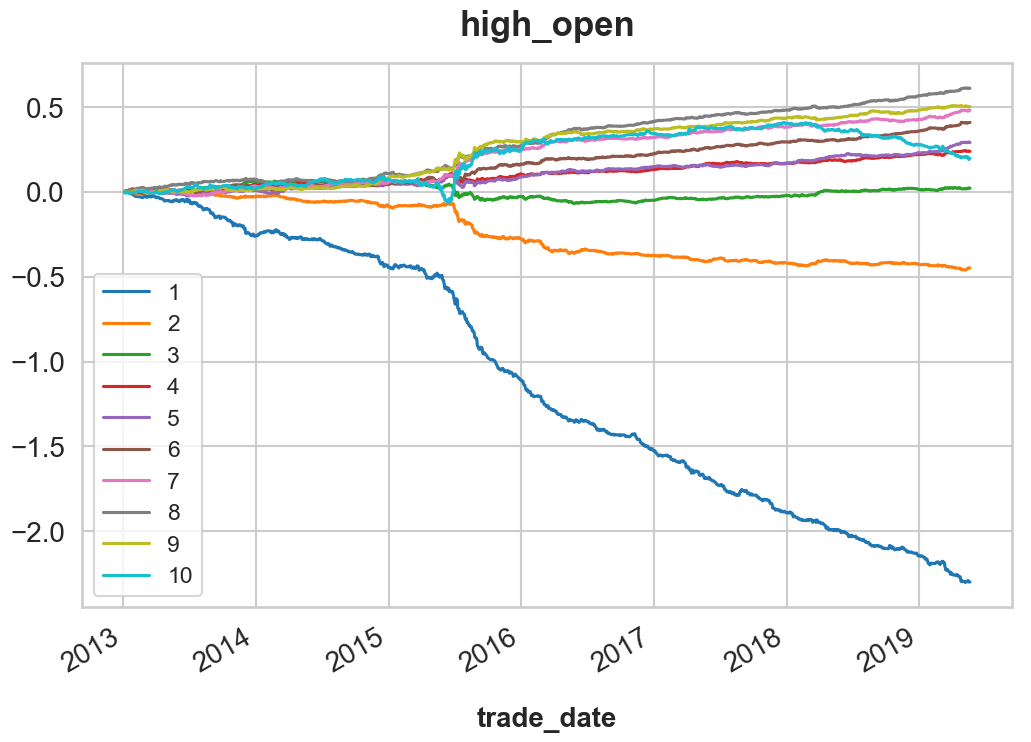

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
sns.set_palette(sns.color_palette())
sns.set_context('talk')
sns.set_style('whitegrid')
params = {
    'figure.figsize': [12, 8],
    'figure.dpi': 100,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.titlesize': 25,
    'axes.titlepad': 20,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 20,
    'axes.labelpad': 20
}
plt.rcParams.update(params)

title = cfg.factor_path.split('/')[-1].split('.')[0]
agg_df.plot(title=title, fontsize=20).get_figure().savefig(path.join(cfg.report_root, title + '.jpg'))